# XGBOOST - REGRESSION - TEST

In [1]:
import numpy as np
from sklearn import datasets
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import pandas as pd
from datetime import datetime
from time import time
from sklearn.metrics import balanced_accuracy_score

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
from sklearn.metrics import confusion_matrix

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
from sklearn.utils.multiclass import unique_labels

In [7]:
import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json

In [8]:
from sklearn.metrics import roc_curve, auc

In [9]:
from functools import partial
import scipy as sp

### GLOBAL VARIABLES

In [10]:
DATAPATH = 'data/train_test/'
SEED = 47
NITER = 100
CV = 3
SCORE = 'rmse'
handlingnull = False
NJOBS = 2
USEGPU = False
NCLASS = 0

### FUNCTIONS

In [11]:
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_xgb(y_pred, y_true):
    """
    Fast cappa eval function for xgb.
    """
    # print('y_true', y_true)
    # print('y_pred', y_pred)
    y_true = y_true.get_label()
    y_pred = y_pred.argmax(axis=1)
    return 'cappa', -qwk(y_true, y_pred)

In [12]:

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [13]:
def sklearn_qwk(y_true, y_pred) -> np.float64:
    """
    Function for measuring Quadratic Weighted Kappa with scikit-learn
    
    :param y_true: The ground truth labels
    :param y_pred: The predicted labels
    
    :return The Quadratic Weighted Kappa Score (QWK)
    """
    return metrics.cohen_kappa_score(y_true, y_pred, weights="quadratic")

In [14]:
def plot_importance(booster, figsize=(10,5), feature_names=None, **kwargs): 
    
    fig, ax = plt.subplots(1,1,figsize=figsize) 
    
    if feature_names:
        mapper = {'f{0}'.format(i): v for i, v in enumerate(feature_names)}
        mapped = {mapper[k]: v for k, v in booster.get_fscore().items()}
        return xgb.plot_importance(mapped, ax=ax, **kwargs)
    else:
        return xgb.plot_importance(booster=booster, ax=ax, **kwargs)
    pass

In [15]:
def plot_score_dist(y_true, y_score):
    
    df = pd.DataFrame(data=np.column_stack((y_true, y_score)), columns=['target','score'])
    
    plt.figure(figsize=(7, 4))
    ax = sns.boxplot(x="target", y="score", data=df)
    ax.set_title("Score distribution")

    pass

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [classes[c] for c in unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### LOAD DATASET

In [17]:
train_features = pd.read_pickle(DATAPATH+'X_train.pkl')

In [18]:
train_labels = pd.read_pickle(DATAPATH+'y_train.pkl')

In [19]:
test_features = pd.read_pickle(DATAPATH+'X_test.pkl')

In [20]:
test_labels = pd.read_pickle(DATAPATH+'y_test.pkl')

In [21]:
train_features.shape

(12383, 89)

In [22]:
test_features.shape

(5307, 89)

In [23]:
### create a DMatrix and handling Null values
if handlingnull:
    #train_features[np.isnan(train_features)] = -9999
    xgtrain = xgb.DMatrix(train_features, train_labels, missing=-9999)
    xgtest = xgb.DMatrix(test_features, missing=-9999)
else:
    xgtrain = xgb.DMatrix(train_features, train_labels)
    xgtest = xgb.DMatrix(test_features)

### TRAIN MODEL

#### Set hyperparameters

In [24]:
# ======== General Parameters ======= #

# Select the type of model to run at each iteration. gbtree or gblinear.
booster = 'gbtree'


# ======== Booster Parameters ======== # 

# Analogous to learning rate in GBM. 
# Typical final values to be used: 0.01-0.2
eta = [0.01] 


# Learning Task Parameters

# This defines the loss function to be minimized. 
objective  = 'reg:linear'


# The metric to be used for validation data.
# - rmse – root mean square error
# - mae – mean absolute error
# - logloss – negative log-likelihood
# - error – Binary classification error rate (0.5 threshold)
# - merror – Multiclass classification error rate
# - mlogloss – Multiclass logloss
# - auc: Area under the curve
#eval_metric = ['rmse','mae']
eval_metric = eval_qwk_xgb

In [25]:
model = XGBRegressor()

In [26]:
model_param = model.get_params()

In [27]:
model_param

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [36]:
model_param['seed'] = SEED
model_param['booster'] = booster
model_param['objective'] = objective
#model_param['n_estimator'] = 300
#model_param['scale_pos_weight'] = scale_pos_weight
model_param['nthread'] = 8
model_param['max_depth'] = 5

In [37]:
early_stopping_rounds = 50

In [38]:
cvresult = xgb.cv(model_param, xgtrain, num_boost_round = 1000, nfold = CV, metrics = ['rmse'], early_stopping_rounds = early_stopping_rounds, seed = SEED)

In [39]:
model_param['n_estimator'] = cvresult.shape[0]

In [40]:
model = xgb.train(model_param, xgtrain, verbose_eval=True)

In [41]:
y_valid_pred = model.predict(xgtrain)

In [42]:
y_pred = model.predict(xgtest)

In [43]:
y_valid_pred.max()

1.9299604

In [105]:
optR = OptimizedRounder()
optR.fit(y_valid_pred, train_labels)
coefficients = optR.coefficients()


In [106]:
valid_predictions = optR.predict(y_valid_pred, coefficients)



In [107]:
np.unique(valid_predictions)

array([0, 1, 2])

In [108]:
test_predictions = optR.predict(y_pred, coefficients)

In [78]:
y_pred_cat = np.zeros(len(y_pred))
for i,v in enumerate(y_pred):
    if v < coefficients[0]:
        y_pred_cat[i] = 0
    elif v >= coefficients[0] and v < coefficients[1]:
        y_pred_cat[i] = 1
    elif v >= coefficients[1] and v < coefficients[2]:
        y_pred_cat[i] = 2
    else:
        y_pred_cat[i] = 3
    
        
        

In [110]:
y_pred.max()

1.8724722

In [82]:
coefficients

array([0.58501372, 1.17813786, 2.60682442])

In [80]:
np.unique(y_pred_cat)

array([0., 1., 2.])

In [60]:
print(SCORE,' : ', mean_squared_error(test_labels,y_pred))

rmse  :  1.4559119619836385


In [61]:
y_pred

array([0.96993315, 1.6073285 , 1.5154091 , ..., 1.6073285 , 1.8521425 ,
       0.8673265 ], dtype=float32)

In [76]:
sklearn_qwk(test_labels, test_predictions)

0.377791392345876

Confusion matrix, without normalization
[[ 305  497  467    0]
 [  52  274  397    0]
 [  27  125  509    0]
 [  41  237 2376    0]]


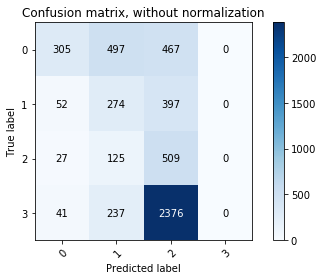

In [54]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(test_labels, test_predictions, classes=['0','1','2','3'],
                      title='Confusion matrix, without normalization')

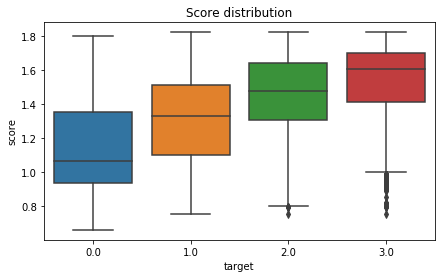

In [70]:
plot_score_dist(test_labels, y_pred)

In [ ]:
# Optimize rounding thresholds (No effect since we have naive baselines)
optR = OptimizedRounder()
optR.fit(y_pred, true_labels)
coefficients = optR.coefficients()
opt_preds = optR.predict(raw_mean_preds, coefficients)
new_score = sklearn_qwk(true_labels, opt_preds)

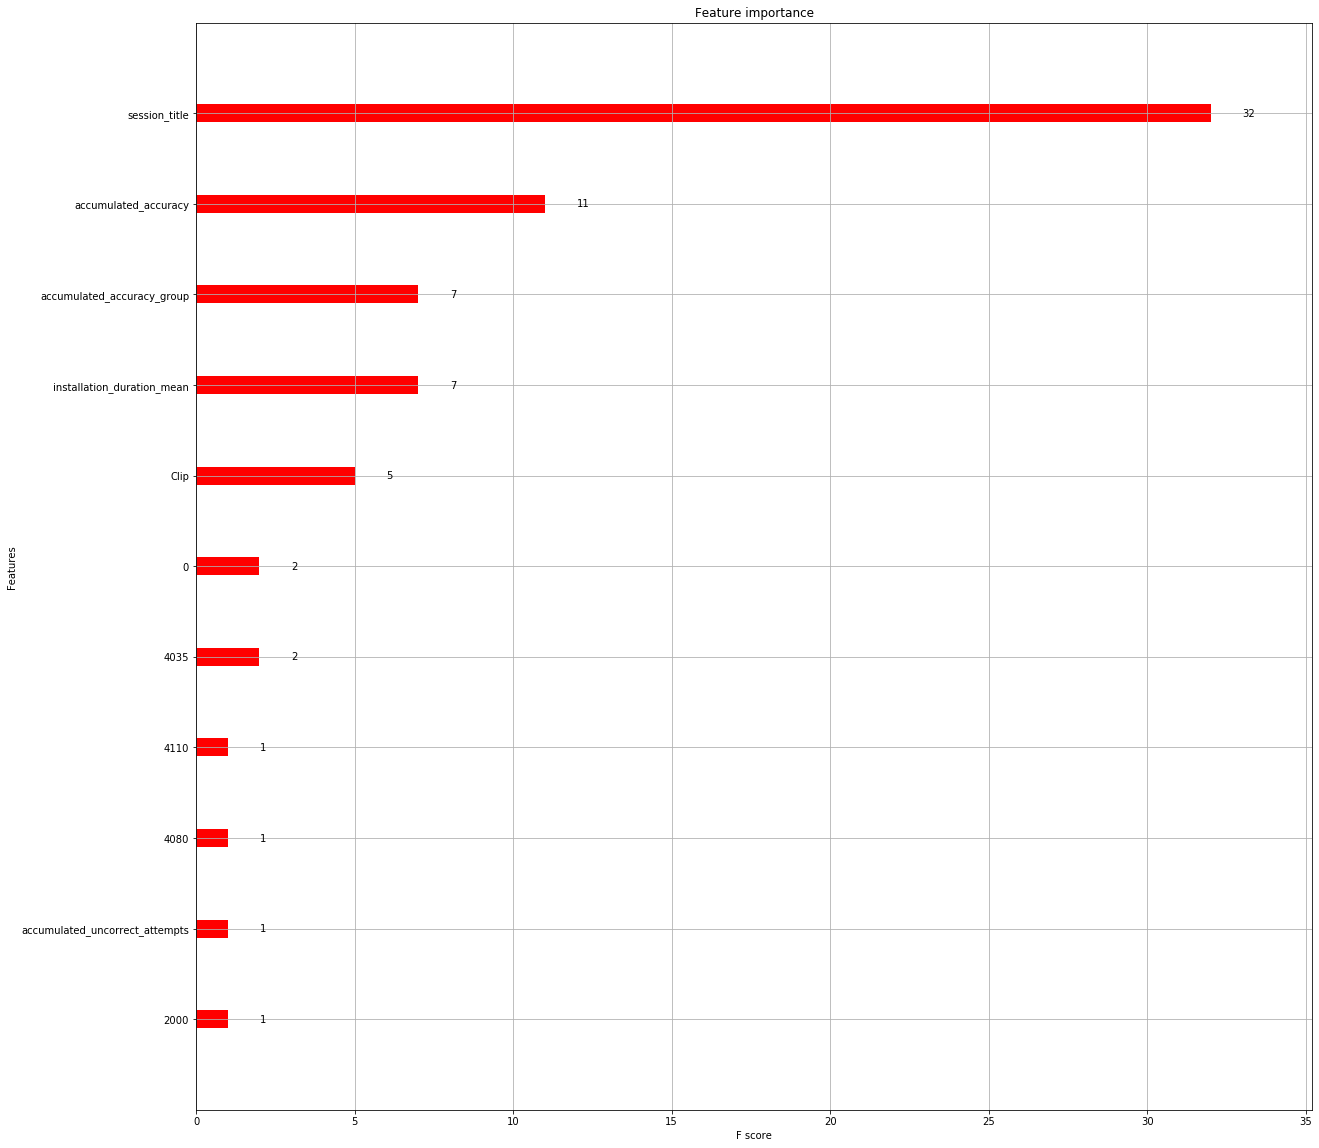

In [42]:
plot_importance(model, figsize=(20,20), feature_names=None, max_num_features=100, color='red')
pass

In [66]:
model.save_model('models/xgb_001.model')